# Phase 3 - Modeling

**Note 1: the following starting code only generates a single random train/test split when default_seed is used. You need to modify the code to generate 100 independent train/test splits with different seeds and report the average results on those independent splits along with standard deviation.**

**Note 2: You are completely free to use your own implementation.**

In [2]:
# Load general utilities
# ----------------------
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import datetime
import numpy as np
import pickle
import time
import seaborn as sns

# Load sklearn utilities
# ----------------------
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, brier_score_loss, mean_squared_error, r2_score

from sklearn.calibration import calibration_curve

# Load classifiers
# ----------------
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier

# Other Packages
# --------------
from scipy.stats import kendalltau
from sklearn.neural_network import MLPRegressor
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from six import StringIO 
from IPython.display import Image  
from sklearn.tree import export_graphviz
# from scipy.interpolate import spline

# Load debugger, if required
#import pixiedust
pd.options.mode.chained_assignment = None #'warn'

# suppress all warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Define a function that, given a CVGridSearch object, finds the
# percentage difference between the best and worst scores
def find_score_variation(cv_model):
    all_scores = cv_model.cv_results_['mean_test_score']
    return( np.abs((max(all_scores) - min(all_scores))) * 100 / max(all_scores) )

    '''
    which_min_score = np.argmin(all_scores)
    
    all_perc_diff = []
    
    try:
        all_perc_diff.append( np.abs(all_scores[which_min_score - 1] - all_scores[which_min_score])*100 / min(all_scores) )
    except:
        pass
    
    try:
        all_perc_diff.append( np.abs(all_scores[which_min_score + 1] - all_scores[which_min_score])*100 / min(all_scores) )
    except:
        pass
    
    return ( np.mean(all_perc_diff) )
    '''

# Define a function that checks, given a CVGridSearch object,
# whether the optimal parameters lie on the edge of the search
# grid
def find_opt_params_on_edge(cv_model):
    out = False
    
    for i in cv_model.param_grid:
        if cv_model.best_params_[i] in [ cv_model.param_grid[i][0], cv_model.param_grid[i][-1] ]:
            out = True
            break
            
    return out

## Define a default random seed and an output file

In [4]:
default_seed = 1
output_file = "output_sample"

In [5]:
# Create a function to print a line to our output file
def dump_to_output(key, value):
    with open(output_file, "a") as f:
        f.write(",".join([str(default_seed), key, str(value)]) + "\n")

## Load the data and engineer the features

In [6]:
# Read the data and features from the pickle file saved in CS-Phase 2
data, discrete_features, continuous_features, ret_cols = pickle.load( open( "clean_data.pickle", "rb" ) )

In [7]:
## Create the outcome columns: True if loan_status is either Charged Off or Default, False otherwise
data["outcome"] = ((data['loan_status'] == 'Charged Off') | (data['loan_status'] == 'Default'))

In [8]:
# Create a feature for the length of a person's credit history at the time the loan is issued
data['cr_hist'] = (data.issue_d - data.earliest_cr_line) / np.timedelta64(1, 'M')
continuous_features.append('cr_hist')

In [9]:
# Copy the data to save current state
data_copy = data.copy()


# Randomly assign each row to a training and test set. We do this now because we will be fitting a variety of models on various time periods, and we would like every period to use the *same* training/test split
np.random.seed(default_seed)
## create the train columns where the value is True if it is a train instance and False otherwise. Hint: use np.random.choice with 70% for training and 30% for testing
indices = np.random.choice(range(len(data)), int(0.7*len(data)), replace=False)

data['train'] = False
data['train'].iloc[list(indices)] = True

# the 'data' variable now refers to the split using the default_seed = 1


In [10]:
# Create a matrix of features and outcomes, with dummies. Record the names of the dummies for later use
X_continuous = data[continuous_features].to_numpy()

X_discrete = pd.get_dummies(data[discrete_features], dummy_na = True, prefix_sep = "::", drop_first = True)
discrete_features_dummies = X_discrete.columns.tolist()
X_discrete = X_discrete.values

X = np.concatenate( (X_continuous, X_discrete), axis = 1 )

y = data.outcome.to_numpy()

train = data.train.to_numpy()


## Prepare functions to fit and evaluate models

In [12]:
def prepare_data(data_subset = np.array([True]*len(data)),
                    n_samples_train = 30000,
                    n_samples_test = 20000,
                    feature_subset = None,
                    date_range_train = (data.issue_d.min(), data.issue_d.max()),
                    date_range_test = (data.issue_d.min(), data.issue_d.max()),
                    random_state = default_seed):
    '''
    This function will prepare the data for classification or regression.
    It expects the following parameters:
      - data_subset: a numpy array with as many entries as rows in the
                     dataset. Each entry should be True if that row
                     should be used, or False if it should be ignored
      - n_samples_train: the total number of samples to be used for training.
                         Will trigger an error if this number is larger than
                         the number of rows available after all filters have
                         been applied
      - n_samples_test: as above for testing
      - feature_subect: A list containing the names of the features to be
                        used in the model. In None, all features in X are
                        used
      - date_range_train: a tuple containing two dates. All rows with loans
                          issued outside of these two dates will be ignored in
                          training
      - date_range_test: as above for testing
      - random_state: the random seed to use when selecting a subset of rows
      
    Note that this function assumes the data has a "Train" column, and will
    select all training rows from the rows with "True" in that column, and all
    the testing rows from those with a "False" in that column.
    
    This function returns a dictionary with the following entries
      - X_train: the matrix of training data
      - y_train: the array of training labels
      - train_set: a Boolean vector with as many entries as rows in the data
                  that denotes the rows that were used in the train set
      - X_test: the matrix of testing data
      - y_test: the array of testing labels
      - test_set: a Boolean vector with as many entries as rows in the data
                  that denotes the rows that were used in the test set
    '''
    
    np.random.seed(random_state)
        
    # Filter down the data to the required date range, and downsample
    # as required
    filter_train = ( train & (data.issue_d >= date_range_train[0]) &
                            (data.issue_d <= date_range_train[1]) & data_subset ).values
    filter_test = ( (train == False) & (data.issue_d >= date_range_test[0])
                            & (data.issue_d <= date_range_test[1]) & data_subset ).values
    
    filter_train[ np.random.choice( np.where(filter_train)[0], size = filter_train.sum()
                                                   - n_samples_train, replace = False ) ] = False
    filter_test[ np.random.choice( np.where(filter_test)[0], size = filter_test.sum()
                                                   - n_samples_test, replace = False ) ] = False
    
    # Prepare the training and test set
    X_train = X[ filter_train , :]
    X_test = X[ filter_test, :]
    if feature_subset != None:
        cols = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in feature_subset]
        X_train = X_train[ : , cols ]
        X_test = X_test[ : , cols ]
        
    y_train = y[ filter_train ]
    y_test = y[ filter_test ]
    
    # Scale the variables
    scaler = preprocessing.MinMaxScaler()

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # return training and testing data
    out = {'X_train':X_train, 'y_train':y_train, 'train_set':filter_train, 
           'X_test':X_test, 'y_test':y_test, 'test_set':filter_test}
    
    return out

In [13]:
def fit_classification(model, data_dict,
                          cv_parameters = {},
                          model_name = None,
                          random_state = default_seed,
                          output_to_file = True,
                          print_to_screen = True):
    '''
    This function will fit a classification model to data and print various evaluation
    measures. It expects the following parameters
      - model: an sklearn model object
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - cv_parameters: a dictionary of parameters that should be optimized
                       over using cross-validation. Specifically, each named
                       entry in the dictionary should correspond to a parameter,
                       and each element should be a list containing the values
                       to optimize over
      - model_name: the name of the model being fit, for printouts
      - random_state: the random seed to use
      - output_to_file: if the results will be saved to the output file
      - print_to_screen: if the results will be printed on screen
    
    If the model provided does not have a predict_proba function, we will
    simply print accuracy diagnostics and return.
    
    If the model provided does have a predict_proba function, we first
    figure out the optimal threshold that maximizes the accuracy and
    print out accuracy diagnostics. We then print an ROC curve, sensitivity/
    specificity curve, and calibration curve.
    
    This function returns a dictionary with the following entries
      - model: the best fitted model
      - y_pred: predictions for the test set
      - y_pred_probs: probability predictions for the test set, if the model
                      supports them
      - y_pred_score: prediction scores for the test set, if the model does not 
                      output probabilities.
    '''
        
    np.random.seed(random_state)
    
    # --------------------------
    #   Step 1 - Load the data
    # --------------------------
    X_train = data_dict['X_train']
    y_train = data_dict['y_train']
    
    X_test = data_dict['X_test']
    y_test = data_dict['y_test']
    
    filter_train = data_dict['train_set']    
  
    # --------------------------
    #   Step 2 - Fit the model
    # --------------------------

    cv_model = GridSearchCV(model, cv_parameters)
    
    start_time = time.time()
    cv_model.fit(X_train, y_train)
    end_time = time.time()
    
    best_model = cv_model.best_estimator_
    
    if print_to_screen:

        if model_name != None:
            print("=========================================================")
            print("  Model: " + model_name)
            print("=========================================================")

        print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
        print("Optimal parameters:")
        print(cv_model.best_params_)
        print("")
    
    # -------------------------------
    #   Step 3 - Evaluate the model
    # -------------------------------
    
    # If possible, make probability predictions
    try:
        y_pred_probs = best_model.predict_proba(X_test)[:,1]
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
        
        probs_predicted = True
    except:
        probs_predicted = False
    
    # Make predictions; if we were able to find probabilities, use
    # the threshold that maximizes the accuracy in the training set.
    # If not, just use the learner's predict function
    if probs_predicted:
        y_train_pred_probs = best_model.predict_proba(X_train)[:,1]
        fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred_probs)
        
        true_pos_train = tpr_train*(y_train.sum())
        true_neg_train = (1 - fpr_train) *(1-y_train).sum()
        
        best_threshold_index = np.argmax(true_pos_train + true_neg_train)
        best_threshold = 1 if best_threshold_index == 0 else thresholds_train[ best_threshold_index ]
        
        if print_to_screen:
            print("Accuracy-maximizing threshold was: " + str(best_threshold))
        
        y_pred = (y_pred_probs > best_threshold)
    else:
        y_pred = best_model.predict(X_test)
    
    if print_to_screen:
        print("Accuracy: ", accuracy_score(y_test, y_pred))
        print(classification_report(y_test, y_pred, target_names =['No default', 'Default'], digits = 4))

    if print_to_screen:
        if probs_predicted:        
            plt.figure(figsize = (13, 4.5))
            plt.subplot(2, 2, 1)

            plt.title("ROC Curve (AUC = %0.2f)"% roc_auc_score(y_test, y_pred_probs))
            plt.plot(fpr, tpr, 'b')
            plt.plot([0,1],[0,1],'r--')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.ylabel('True Positive Rate')
            plt.xlabel('False Positive Rate')

            plt.subplot(2, 2, 3)

            plt.plot(thresholds, tpr, 'b', label = 'Sensitivity')
            plt.plot(thresholds, 1 -fpr, 'r', label = 'Specificity')
            plt.legend(loc = 'lower right')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.xlabel('Threshold')

            plt.subplot(2, 2, 2)

            fp_0, mpv_0 = calibration_curve(y_test, y_pred_probs, n_bins = 10)
            plt.plot([0,1], [0,1], 'k:', label='Perfectly calibrated')
            plt.plot(mpv_0, fp_0, 's-')
            plt.ylabel('Fraction of Positives')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.legend(loc ='upper left')
            
            plt.subplot(2, 2, 4)
            plt.hist(y_pred_probs, range=(0, 1), bins=10, histtype="step", lw=2)
            plt.xlim([0,1]); plt.ylim([0,20000])
            plt.xlabel('Mean Predicted Probability')
            plt.ylabel('Count')
            
            #plt.tight_layout()
            plt.show()
        
    # Additional Score Check
    if probs_predicted:
        y_train_score = y_train_pred_probs
    else:
        y_train_score = best_model.decision_function(X_train)
        
    tau, p_value = kendalltau(y_train_score, data.grade[filter_train])
    if print_to_screen:
        print("")
        print("Similarity to LC grade ranking: ", tau)
    
    if probs_predicted:
        brier_score = brier_score_loss(y_test, y_pred_probs)
        if print_to_screen:
            print("Brier score:", brier_score)
    
    # Return the model predictions, and the
    # test set
    # -------------------------------------
    out = {'model':best_model, 'y_pred_labels':y_pred}
    
    if probs_predicted:
        out.update({'y_pred_probs':y_pred_probs})
    else:
        y_pred_score = best_model.decision_function(X_test)
        out.update({'y_pred_score':y_pred_score})
        
    # Output results to file
    # ----------------------
    if probs_predicted and output_to_file:
        # Check whether any of the CV parameters are on the edge of
        # the search space
        opt_params_on_edge = find_opt_params_on_edge(cv_model)
        dump_to_output(model_name + "::search_on_edge", opt_params_on_edge)
        if print_to_screen:
            print("Were parameters on edge? : " + str(opt_params_on_edge))
        
        # Find out how different the scores are for the different values
        # tested for by cross-validation. If they're not too different, then
        # even if the parameters are off the edge of the search grid, we should
        # be ok
        score_variation = find_score_variation(cv_model)
        dump_to_output(model_name + "::score_variation", score_variation)
        if print_to_screen:
            print("Score variations around CV search grid : " + str(score_variation))
        
        # Print out all the scores
        dump_to_output(model_name + "::all_cv_scores", str(cv_model.cv_results_['mean_test_score']))
        if print_to_screen:
            print( str(cv_model.cv_results_['mean_test_score']) )
        
        # Dump the AUC to file
        dump_to_output(model_name + "::roc_auc", roc_auc_score(y_test, y_pred_probs) )
        
    return out

## Prepare functions to create 100 independent test/train splits- Sai

#### Code for Saving 100 Independent Test/Train Splits

In [14]:
def prepare_data_for_n_test_train_splits(data,
                    discrete_features_dummies,
                    X,
                    y,
                    train,
                    n_samples_train = 30000,
                    n_samples_test = 20000,
                    feature_subset = None,
                    random_state = default_seed):

    data_subset = np.array([True]*len(data))
    
    date_range_train = (data.issue_d.min(), data.issue_d.max())
    date_range_test = (data.issue_d.min(), data.issue_d.max())
    
    np.random.seed(random_state)
        
    # Filter down the data to the required date range, and downsample
    # as required
    filter_train = ( train & (data.issue_d >= date_range_train[0]) &
                            (data.issue_d <= date_range_train[1]) & data_subset ).values
    filter_test = ( (train == False) & (data.issue_d >= date_range_test[0])
                            & (data.issue_d <= date_range_test[1]) & data_subset ).values
    
    filter_train[ np.random.choice( np.where(filter_train)[0], size = filter_train.sum()
                                                   - n_samples_train, replace = False ) ] = False
    filter_test[ np.random.choice( np.where(filter_test)[0], size = filter_test.sum()
                                                   - n_samples_test, replace = False ) ] = False
    
    # Prepare the training and test set
    X_train = X[ filter_train , :]
    X_test = X[ filter_test, :]
    if feature_subset != None:
        cols = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in feature_subset]
        X_train = X_train[ : , cols ]
        X_test = X_test[ : , cols ]
        
    y_train = y[ filter_train ]
    y_test = y[ filter_test ]
    
    # Scale the variables
    scaler = preprocessing.MinMaxScaler()

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # return training and testing data
    out = {'X_train':X_train, 'y_train':y_train, 'train_set':filter_train, 
           'X_test':X_test, 'y_test':y_test, 'test_set':filter_test}
    
    return out

In [15]:
# input copy of original data -> 'data_copy' (before default_seed random split)
def n_train_test_splits(data, num_seeds, feature_subset): 
    out = []
    seeds = [np.random.randint(1,10000) for i in range (0, num_seeds)]
    
    for seed in seeds:
        np.random.seed(seed)
        
        # Store a copy of the input data
        data_copy = data.copy()
        
        indices = np.random.choice(range(len(data_copy)), int(0.7*len(data_copy)), replace=False)

        data_copy['train'] = False
        data_copy['train'].iloc[list(indices)] = True
                
        # Create a matrix of features and outcomes, with dummies. Record the names of the dummies for later use
        X_continuous = data_copy[continuous_features].to_numpy()

        X_discrete = pd.get_dummies(data_copy[discrete_features], dummy_na = True, prefix_sep = "::", drop_first = True)
        discrete_features_dummies = X_discrete.columns.tolist() 
        X_discrete = X_discrete.values

        X = np.concatenate( (X_continuous, X_discrete), axis = 1 ) 

        y = data_copy.outcome.to_numpy() #


        train = data_copy.train.to_numpy() #
        
        
        out.append(prepare_data_for_n_test_train_splits(data_copy, discrete_features_dummies, X, y, train, feature_subset=feature_subset, random_state=seed))
        
    # Returns a list of data_dicts which can be accessed by indexing
    return out
      
        

In [16]:
## define your set of features to use in different models

#### we might need to remove some of these features- Sai
your_features = ['id', 'loan_amnt', 
                'funded_amnt', 'term', 'int_rate', 'grade', 'emp_length', 'home_ownership',
                'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'purpose','dti',
                'delinq_2yrs', 'earliest_cr_line', 'open_acc', 'pub_rec', 'fico_range_high',
                'fico_range_low', 'revol_bal', 'revol_util', 'total_pymnt', 'recoveries', 'last_pymnt_d']


# prepare the train, test data for training models
data_dict = prepare_data(feature_subset = your_features)

all_features = pd.Series(continuous_features + discrete_features_dummies)
idx = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in your_features]
selected_features = all_features[idx]
selected_features.reset_index(drop=True,inplace=True)

In [71]:
# Don't run this cell if you have 'hundred_train_test_splits.npy'
hundred_train_test_splits = n_train_test_splits(data_copy, 100, feature_subset = your_features)
np.save('hundred_train_test_splits.npy', hundred_train_test_splits)

In [17]:
hundred_train_test_splits = np.load('hundred_train_test_splits.npy', allow_pickle='TRUE')

In [18]:
compare1 = hundred_train_test_splits[0]['X_train']
compare2 = hundred_train_test_splits[57]['X_train']

print(len(hundred_train_test_splits))

100


## Train and Test different machine learning classification models

The machine learning models listed in the following are just our suggestions. You are free to try any other models that you would like to experiment with.

### Naive Bayes

  Model: Naive Bayes
Fit time: 0.32 seconds
Optimal parameters:
{}

Accuracy-maximizing threshold was: 1
Accuracy:  0.8061
              precision    recall  f1-score   support

  No default     0.8061    1.0000    0.8926     16122
     Default     0.0000    0.0000    0.0000      3878

    accuracy                         0.8061     20000
   macro avg     0.4031    0.5000    0.4463     20000
weighted avg     0.6498    0.8061    0.7196     20000



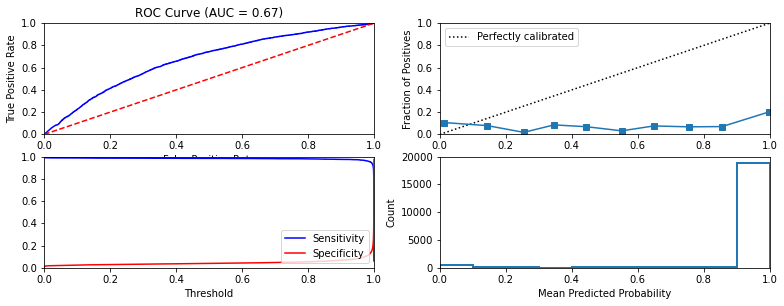


Similarity to LC grade ranking:  0.6267217769384938
Brier score: 0.7645927304441887
Were parameters on edge? : False
Score variations around CV search grid : 0.0
[0.25623333]


In [56]:
## Train and test a naive bayes classifier
#  out = {'X_train':X_train, 'y_train':y_train, 'train_set':filter_train, 
#            'X_test':X_test, 'y_test':y_test, 'test_set':filter_test}
    
#     return out
gnb = GaussianNB()
gnb = fit_classification(gnb, data_dict, model_name="Naive Bayes")

### $l_1$ regularized logistic regression

  Model: l1 Regularized Logistic Regression
Fit time: 98.65 seconds
Optimal parameters:
{'C': 0.1}

Accuracy-maximizing threshold was: 0.48318412971776015
Accuracy:  0.80855
              precision    recall  f1-score   support

  No default     0.8122    0.9918    0.8931     16122
     Default     0.5783    0.0467    0.0864      3878

    accuracy                         0.8085     20000
   macro avg     0.6952    0.5192    0.4897     20000
weighted avg     0.7669    0.8085    0.7367     20000



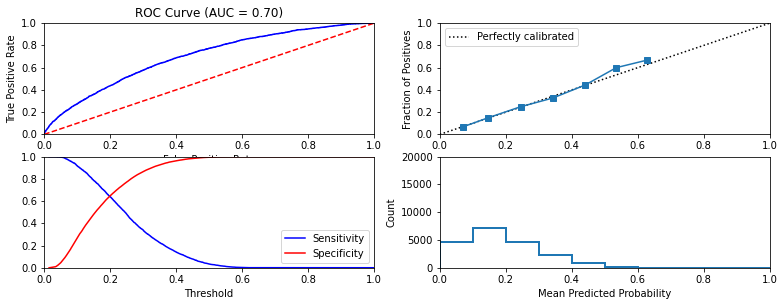


Similarity to LC grade ranking:  0.6930825094927892
Brier score: 0.14374543467470272
Were parameters on edge? : False
Score variations around CV search grid : 0.30941870539214383
[0.80546667 0.80796667 0.80783333 0.80783333 0.80783333 0.80783333]


In [58]:
## Train and test a l_1 regularized logistic regression classifier

l1_logistic = LogisticRegression(penalty='l1', solver='liblinear')
cv_parameters = {'C':[0.01, 0.1, 1, 10, 100, 1000]}

l1_logistic = fit_classification(l1_logistic, data_dict, cv_parameters, model_name='l1 Regularized Logistic Regression')

### $l_2$ regularized logistic regression

  Model: l2 Regularized Logistic Regression
Fit time: 9.77 seconds
Optimal parameters:
{'C': 0.1}

Accuracy-maximizing threshold was: 0.5032529598001801
Accuracy:  0.8085
              precision    recall  f1-score   support

  No default     0.8109    0.9944    0.8933     16122
     Default     0.6043    0.0358    0.0677      3878

    accuracy                         0.8085     20000
   macro avg     0.7076    0.5151    0.4805     20000
weighted avg     0.7708    0.8085    0.7332     20000



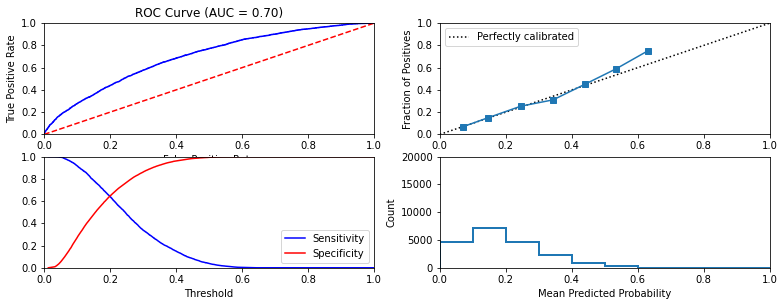


Similarity to LC grade ranking:  0.6922106762166303
Brier score: 0.14373484938582554
Were parameters on edge? : False
Score variations around CV search grid : 0.21445067634444462
[0.80653333 0.80826667 0.80783333 0.8079     0.80786667 0.80786667]


In [66]:
## Train and test a l_2 regularized logistic regression classifier

l2_logistic = LogisticRegression(penalty='l2', solver='liblinear')
cv_parameters = {'C':[0.01, 0.1, 1, 10, 100, 1000]}

l2_logistic = fit_classification(l2_logistic, data_dict, cv_parameters, model_name='l2 Regularized Logistic Regression')

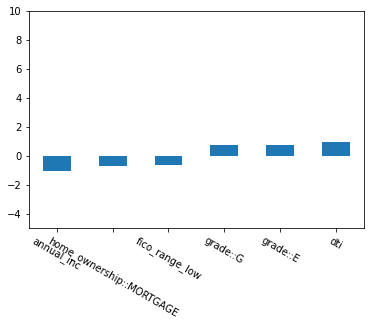

In [33]:
## plot top 3 features with the most positive (and negative) weights 
top_and_bottom_idx = list(np.argsort(l2_logistic['model'].coef_)[0,:3]) + list(np.argsort(l2_logistic['model'].coef_)[0,-3:])
bplot = pd.Series(l2_logistic['model'].coef_[0,top_and_bottom_idx])
xticks = selected_features[top_and_bottom_idx]
p1 = bplot.plot(kind='bar',rot=-30,ylim=(-5,10))
p1.set_xticklabels(xticks)
plt.show()

### Decision tree

In [ ]:
## Train and test a decision tree classifier

decision_tree = ...
cv_parameters = ...

decision_tree = fit_classification(...)

### Random forest

In [ ]:
## Train and test a random forest classifier

random_forest = ...
cv_parameters = ...

random_forest = fit_classification(...)

In [ ]:
## Plot top 6 most significant features
top_idx = list(np.argsort(random_forest['model'].feature_importances_)[-6:]) 
bplot = pd.Series(random_forest['model'].feature_importances_[top_idx])
xticks = selected_features[top_idx]
p2 = bplot.plot(kind='bar',rot=-30,ylim=(0,0.2))
p2.set_xticklabels(xticks)
plt.show()

### Multi-layer perceptron

In [ ]:
## Train and test a multi-layer perceptron classifier

mlp = ...
cv_parameters = ...

mlp = fit_classification(...)

## Train and Test logistic regression model with features derived by LendingClub

In [ ]:
## Find a lendingClub-defined feature and train a l1-regularized logistic regression model on data with only that feature
a_lendingclub_feature = ...

data_dict = prepare_data(feature_subset = a_lendingclub_feature)
lc1_only_logistic = ...

lc1_only_logistic = fit_classification(...)

In [ ]:
## train a l2-regularized logistic regression model on data with only that feature
lc2_only_logistic = ...

lc2_only_logistic = fit_classification(...)

## Train and test all the models you have tried previously after removing features derived by LendingClub 

In [ ]:
...

## Time stability test of YOURMODEL

In [ ]:
## Define the time window of your train and test data
start_date_train = ...
end_date_train = ...
start_date_test = ...
end_date_test = ...

data_dict_test = prepare_data(date_range_train = (start_date_train, end_date_train), 
                         date_range_test = (start_date_test, end_date_test),
                         n_samples_train = 9000, n_samples_test = 7000, feature_subset = your_features)

## Train and test YOURMODEL using this data
cv_parameters = ...

fit_classification(...)

## Train and test YOURMODEL on the original data

In [ ]:
...

## Test regression models

In [19]:
def fit_regression(model, data_dict,
                      cv_parameters = {},
                      separate = False, 
                      model_name = None,
                      random_state = default_seed,
                      output_to_file = True,
                      print_to_screen = True):
    '''
    This function will fit a regression model to data and print various evaluation
    measures. It expects the following parameters
      - model: an sklearn model object
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - separate: a Boolean variable indicating whether we fit models for 
                  defaulted and non-defaulted loans separately
      - cv_parameters: a dictionary of parameters that should be optimized
                       over using cross-validation. Specifically, each named
                       entry in the dictionary should correspond to a parameter,
                       and each element should be a list containing the values
                       to optimize over      
      - model_name: the name of the model being fit, for printouts
      - random_state: the random seed to use
      - output_to_file: if the results will be saved to the output file
      - print_to_screen: if the results will be printed on screen
    
    This function returns a dictionary FOR EACH RETURN DEFINITION with the following entries
      - model: the best fitted model
      - predicted_return: prediction result based on the test set
      - predicted_regular_return: prediction result for non-defaulted loans (valid if separate == True)
      - predicted_default_return: prediction result for defaulted loans (valid if separate == True)
      - r2_scores: the testing r2_score(s) for the best fitted model
    '''
    
    np.random.seed(random_state)
    
    # --------------------------
    #   Step 1 - Load the data
    # --------------------------
    
    col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']
    
    X_train = data_dict['X_train']
    filter_train = data_dict['train_set']  

    X_test = data_dict['X_test']
    filter_test = data_dict['test_set']
    out = {}
    
    for ret_col in col_list:
        
        y_train = data.loc[filter_train, ret_col].to_numpy()
        y_test = data.loc[filter_test, ret_col].to_numpy()

        # --------------------------
        #   Step 2 - Fit the model
        # --------------------------

        if separate:
            outcome_train = data.loc[filter_train, 'outcome']
            outcome_test = data.loc[filter_test, 'outcome']

            # Train two separate regressors for defaulted and non-defaulted loans
            X_train_0 = X_train[outcome_train == False]
            y_train_0 = y_train[outcome_train == False]
            X_test_0 = X_test[outcome_test == False]
            y_test_0 = y_test[outcome_test == False]

            X_train_1 = X_train[outcome_train == True]
            y_train_1 = y_train[outcome_train == True]
            X_test_1 = X_test[outcome_test == True]
            y_test_1 = y_test[outcome_test == True]

            cv_model_0 = GridSearchCV(model, cv_parameters, scoring='r2')
            cv_model_1 = GridSearchCV(model, cv_parameters, scoring='r2')

            start_time = time.time()
            cv_model_0.fit(X_train_0, y_train_0)
            cv_model_1.fit(X_train_1, y_train_1)
            end_time = time.time()

            best_model_0 = cv_model_0.best_estimator_
            best_model_1 = cv_model_1.best_estimator_
            
            if print_to_screen:

                if model_name != None:
                    print("=========================================================")
                    print("  Model: " + model_name + "  Return column: " + ret_col)
                    print("=========================================================")

                print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
                print("Optimal parameters:")
                print("model_0:",cv_model_0.best_params_, "model_1",cv_model_1.best_params_)

            predicted_regular_return = best_model_0.predict(X_test)
            predicted_default_return = best_model_1.predict(X_test)
            
            if print_to_screen:
                print("")
                print("Testing r2 scores:")
            # Here we use different testing set to report the performance
            test_scores = {'model_0':r2_score(y_test_0,best_model_0.predict(X_test_0)),
                              'model_1':r2_score(y_test_1,best_model_1.predict(X_test_1))}
            if print_to_screen:
                print("model_0:", test_scores['model_0'])
                print("model_1:", test_scores['model_1'])

            cv_objects = {'model_0':cv_model_0, 'model_1':cv_model_1}
            out[ret_col] = { 'model_0':best_model_0, 'model_1':best_model_1, 'predicted_regular_return':predicted_regular_return,
                      'predicted_default_return':predicted_default_return,'r2_scores':test_scores }

        else:
            cv_model = GridSearchCV(model, cv_parameters, scoring='r2')

            start_time = time.time()
            cv_model.fit(X_train, y_train)
            end_time = time.time()

            best_model = cv_model.best_estimator_
            
            if print_to_screen:
                if model_name != None:
                    print("=========================================================")
                    print("  Model: " + model_name + "  Return column: " + ret_col)
                    print("=========================================================")

                print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
                print("Optimal parameters:")
                print(cv_model.best_params_)

            predicted_return = best_model.predict(X_test)
            test_scores = {'model':r2_score(y_test,predicted_return)}
            if print_to_screen:
                print("")
                print("Testing r2 score:", test_scores['model'])

            cv_objects = {'model':cv_model}
            out[ret_col] = {'model':best_model, 'predicted_return':predicted_return, 'r2_scores':r2_score(y_test,predicted_return)}

        # Output the results to a file
        if output_to_file:
            for i in cv_objects:
                # Check whether any of the CV parameters are on the edge of
                # the search space
                opt_params_on_edge = find_opt_params_on_edge(cv_objects[i])
                dump_to_output(model_name + "::" + ret_col + "::search_on_edge", opt_params_on_edge)
                if print_to_screen:
                    print("Were parameters on edge (" + i + ") : " + str(opt_params_on_edge))

                # Find out how different the scores are for the different values
                # tested for by cross-validation. If they're not too different, then
                # even if the parameters are off the edge of the search grid, we should
                # be ok
                score_variation = find_score_variation(cv_objects[i])
                dump_to_output(model_name + "::" + ret_col + "::score_variation", score_variation)
                if print_to_screen:
                    print("Score variations around CV search grid (" + i + ") : " + str(score_variation))

                # Print out all the scores
                dump_to_output(model_name + "::all_cv_scores", str(cv_objects[i].cv_results_['mean_test_score']))
                if print_to_screen:
                    print("All test scores : " + str(cv_objects[i].cv_results_['mean_test_score']) )

                # Dump the AUC to file
                dump_to_output( model_name + "::" + ret_col + "::r2", test_scores[i] )

    return out

### $l_1$ regularized linear regression

In [20]:
## First, trying l1 regularized linear regression with hyper-parameters
# says there are continuous features in the dataset still 

cv_parameters = {'alpha' : [1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,20,30,35,40,45,50,55,100]}

reg_lasso = fit_regression(model = linear_model.Lasso(), data_dict = data_dict, cv_parameters=cv_parameters, model_name='L1 Regularization')

  Model: L1 Regularization  Return column: ret_PESS
Fit time: 13.1 seconds
Optimal parameters:
{'alpha': 0.001}

Testing r2 score: 0.012249729062838166
Were parameters on edge (model) : False
Score variations around CV search grid (model) : -9.480315540855411
All test scores : [-0.10172411 -0.10172407 -0.10172084 -0.10046612 -0.10999063 -0.10999063
 -0.10999063 -0.10999063 -0.10999063 -0.10999063 -0.10999063 -0.10999063
 -0.10999063 -0.10999063 -0.10999063 -0.10999063]
  Model: L1 Regularization  Return column: ret_OPT
Fit time: 14.45 seconds
Optimal parameters:
{'alpha': 1e-08}

Testing r2 score: 0.02983268479793766
Were parameters on edge (model) : False
Score variations around CV search grid (model) : 171.08745117957218
All test scores : [ 0.01613392  0.01613393  0.01613457  0.0043736  -0.01146966 -0.01146966
 -0.01146966 -0.01146966 -0.01146966 -0.01146966 -0.01146966 -0.01146966
 -0.01146966 -0.01146966 -0.01146966 -0.01146966]
  Model: L1 Regularization  Return column: ret_INTa
F

### $l_2$ regularized linear regressor

In [83]:
## trying l2 regularized linear regression with hyper-parameters
cv_parameters = {'alpha' : [1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,20,30,35,40,45,50,55,100]}

reg_ridge= fit_regression(model = linear_model.Ridge(), data_dict = data_dict, cv_parameters=cv_parameters, model_name='L2 Regularization')

  Model: L2 Regularization  Return column: ret_PESS
Fit time: 1.58 seconds
Optimal parameters:
{'alpha': 100}

Testing r2 score: 0.026405799059560975
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -10.973257544985458
All test scores : [-0.10182769 -0.10184679 -0.10184683 -0.10183336 -0.10182651 -0.10119972
 -0.09934751 -0.09777991 -0.09581436 -0.09461547 -0.09417451 -0.09380497
 -0.09349099 -0.09322112 -0.09298694 -0.09177601]
  Model: L2 Regularization  Return column: ret_OPT
Fit time: 1.74 seconds
Optimal parameters:
{'alpha': 5}

Testing r2 score: 0.029747847949786133
Were parameters on edge (model) : False
Score variations around CV search grid (model) : 11.099252648068843
All test scores : [0.01599672 0.01599973 0.01599978 0.01601045 0.01601404 0.01618197
 0.01632988 0.01630633 0.01609227 0.01584428 0.01572507 0.01561083
 0.01550159 0.01539701 0.01529665 0.01451739]
  Model: L2 Regularization  Return column: ret_INTa
Fit time: 1.24 seconds


### Multi-layer perceptron regressor

In [84]:
## trying multi-layer perceptron regression with hyper-parameters
# takes a long time 

cv_parameters = {'activation': ['identity', 'logistic', 'tanh', 'relu'], 'alpha': [0.0001, 0.001, 0.01, 0.1, 1]}

reg_mlp = fit_regression(model = MLPRegressor(), data_dict = data_dict, cv_parameters = cv_parameters, model_name = 'Multi-Layer Perceptron Regressor')

  Model: Multi-Layer Perceptron Regressor  Return column: ret_PESS
Fit time: 169.29 seconds
Optimal parameters:
{'activation': 'relu', 'alpha': 0.1}

Testing r2 score: 0.024345828544853343
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -196.9908835356282
All test scores : [-0.16685411 -0.21354083 -0.24111691 -0.08656409 -0.08166579 -0.15868999
 -0.11526128 -0.10017778 -0.08884188 -0.16665307 -0.22460192 -0.11749816
 -0.15892861 -0.12023588 -0.09759577 -0.14750916 -0.1818608  -0.18873107
 -0.08118664 -0.10885188]
  Model: Multi-Layer Perceptron Regressor  Return column: ret_OPT
Fit time: 170.95 seconds
Optimal parameters:
{'activation': 'tanh', 'alpha': 0.1}

Testing r2 score: 0.024001961115695747
Were parameters on edge (model) : False
Score variations around CV search grid (model) : 445.485760307506
All test scores : [-0.01797246 -0.01445692 -0.00498048  0.00136231 -0.00863797  0.01109075
 -0.01566418 -0.00256415 -0.00121992 -0.02257103 -0.0151

### Random forest regressor

In [85]:
## trying random forest regression with hyper-parameters
# takes a long time

cv_parameters = {'n_estimators': [10, 100], 'max_depth': [None, 3, 5], 'min_impurity_decrease': [0.0, 1.0, 3.0]}

reg_rf = fit_regression(model=RandomForestRegressor(), data_dict = data_dict, cv_parameters = cv_parameters, model_name = 'Random Forest Regressor')

  Model: Random Forest Regressor  Return column: ret_PESS
Fit time: 306.65 seconds
Optimal parameters:
{'max_depth': 5, 'min_impurity_decrease': 0.0, 'n_estimators': 100}

Testing r2 score: 0.028032939328775486
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -146.06693510035606
All test scores : [-0.23580626 -0.12741361 -0.10949959 -0.1097267  -0.10968233 -0.10972479
 -0.10881304 -0.10573732 -0.11180852 -0.11025835 -0.10990087 -0.1096502
 -0.09973091 -0.09583013 -0.10982957 -0.10989072 -0.11028821 -0.1103605 ]
  Model: Random Forest Regressor  Return column: ret_OPT
Fit time: 286.58 seconds
Optimal parameters:
{'max_depth': 5, 'min_impurity_decrease': 0.0, 'n_estimators': 100}

Testing r2 score: 0.03368381850683566
Were parameters on edge (model) : True
Score variations around CV search grid (model) : 920.133138531691
All test scores : [-0.13121471 -0.02330588 -0.01138251 -0.01141208 -0.01118    -0.0114806
  0.01000988  0.01133207 -0.01145859 -0.

## Running a classification model on the 100 Train/Test Splits

In [63]:
def best_params_fit_classification(model_dict, data_dict,
                          cv_parameters = {},
                          model_name = None,
                          random_state = default_seed,
                          output_to_file = True,
                          print_to_screen = True):
    '''
    This function will fit a classification model to data and print various evaluation
    measures. It expects the following parameters
      - model: an sklearn model object
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - cv_parameters: a dictionary of parameters that should be optimized
                       over using cross-validation. Specifically, each named
                       entry in the dictionary should correspond to a parameter,
                       and each element should be a list containing the values
                       to optimize over
      - model_name: the name of the model being fit, for printouts
      - random_state: the random seed to use
      - output_to_file: if the results will be saved to the output file
      - print_to_screen: if the results will be printed on screen
    
    If the model provided does not have a predict_proba function, we will
    simply print accuracy diagnostics and return.
    
    If the model provided does have a predict_proba function, we first
    figure out the optimal threshold that maximizes the accuracy and
    print out accuracy diagnostics. We then print an ROC curve, sensitivity/
    specificity curve, and calibration curve.
    
    This function returns a dictionary with the following entries
      - model: the best fitted model
      - y_pred: predictions for the test set
      - y_pred_probs: probability predictions for the test set, if the model
                      supports them
      - y_pred_score: prediction scores for the test set, if the model does not 
                      output probabilities.
    '''
        
    np.random.seed(random_state)
    
    # --------------------------
    #   Step 1 - Load the data
    # --------------------------
    X_train = data_dict['X_train']
    y_train = data_dict['y_train']
    
    X_test = data_dict['X_test']
    y_test = data_dict['y_test']
    
    filter_train = data_dict['train_set']    
  
    # --------------------------
    #   Step 2 - Fit the model
    # --------------------------

    cv_model = GridSearchCV(model_dict['model'], cv_parameters)
    
    start_time = time.time()
    cv_model.fit(X_train, y_train)
    end_time = time.time()
    
    best_model = cv_model.best_estimator_
    
    if print_to_screen:

        if model_name != None:
            print("=========================================================")
            print("  Model: " + model_name)
            print("=========================================================")

        print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
        print("Optimal parameters:")
        print(cv_model.best_params_)
        print("")
    
    # -------------------------------
    #   Step 3 - Evaluate the model
    # -------------------------------
    
    # If possible, make probability predictions
    try:
        y_pred_probs = best_model.predict_proba(X_test)[:,1]
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
        
        probs_predicted = True
    except:
        probs_predicted = False
    
    # Make predictions; if we were able to find probabilities, use
    # the threshold that maximizes the accuracy in the training set.
    # If not, just use the learner's predict function
    if probs_predicted:
        y_train_pred_probs = best_model.predict_proba(X_train)[:,1]
        fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred_probs)
        
        true_pos_train = tpr_train*(y_train.sum())
        true_neg_train = (1 - fpr_train) *(1-y_train).sum()
        
        best_threshold_index = np.argmax(true_pos_train + true_neg_train)
        best_threshold = 1 if best_threshold_index == 0 else thresholds_train[ best_threshold_index ]
        
        if print_to_screen:
            print("Accuracy-maximizing threshold was: " + str(best_threshold))
        
        y_pred = (y_pred_probs > best_threshold)
    else:
        y_pred = best_model.predict(X_test)
    
    if print_to_screen:
        print("Accuracy: ", accuracy_score(y_test, y_pred))
        print(classification_report(y_test, y_pred, target_names =['No default', 'Default'], digits = 4))

    if print_to_screen:
        if probs_predicted:        
            plt.figure(figsize = (13, 4.5))
            plt.subplot(2, 2, 1)

            plt.title("ROC Curve (AUC = %0.2f)"% roc_auc_score(y_test, y_pred_probs))
            plt.plot(fpr, tpr, 'b')
            plt.plot([0,1],[0,1],'r--')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.ylabel('True Positive Rate')
            plt.xlabel('False Positive Rate')

            plt.subplot(2, 2, 3)

            plt.plot(thresholds, tpr, 'b', label = 'Sensitivity')
            plt.plot(thresholds, 1 -fpr, 'r', label = 'Specificity')
            plt.legend(loc = 'lower right')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.xlabel('Threshold')

            plt.subplot(2, 2, 2)

            fp_0, mpv_0 = calibration_curve(y_test, y_pred_probs, n_bins = 10)
            plt.plot([0,1], [0,1], 'k:', label='Perfectly calibrated')
            plt.plot(mpv_0, fp_0, 's-')
            plt.ylabel('Fraction of Positives')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.legend(loc ='upper left')
            
            plt.subplot(2, 2, 4)
            plt.hist(y_pred_probs, range=(0, 1), bins=10, histtype="step", lw=2)
            plt.xlim([0,1]); plt.ylim([0,20000])
            plt.xlabel('Mean Predicted Probability')
            plt.ylabel('Count')
            
            #plt.tight_layout()
            plt.show()
        
    # Additional Score Check
    if probs_predicted:
        y_train_score = y_train_pred_probs
    else:
        y_train_score = best_model.decision_function(X_train)
        
    tau, p_value = kendalltau(y_train_score, data.grade[filter_train])
    if print_to_screen:
        print("")
        print("Similarity to LC grade ranking: ", tau)
    
    if probs_predicted:
        brier_score = brier_score_loss(y_test, y_pred_probs)
        if print_to_screen:
            print("Brier score:", brier_score)
    
    # Return the model predictions, and the
    # test set
    # -------------------------------------
    out = {'model':best_model, 'y_pred_labels':y_pred}
    
    if probs_predicted:
        out.update({'y_pred_probs':y_pred_probs})
    else:
        y_pred_score = best_model.decision_function(X_test)
        out.update({'y_pred_score':y_pred_score})
        
    # Output results to file
    # ----------------------
    if probs_predicted and output_to_file:
        # Check whether any of the CV parameters are on the edge of
        # the search space
        opt_params_on_edge = find_opt_params_on_edge(cv_model)
        dump_to_output(model_name + "::search_on_edge", opt_params_on_edge)
        if print_to_screen:
            print("Were parameters on edge? : " + str(opt_params_on_edge))
        
        # Find out how different the scores are for the different values
        # tested for by cross-validation. If they're not too different, then
        # even if the parameters are off the edge of the search grid, we should
        # be ok
        score_variation = find_score_variation(cv_model)
        dump_to_output(model_name + "::score_variation", score_variation)
        if print_to_screen:
            print("Score variations around CV search grid : " + str(score_variation))
        
        # Print out all the scores
        dump_to_output(model_name + "::all_cv_scores", str(cv_model.cv_results_['mean_test_score']))
        if print_to_screen:
            print( str(cv_model.cv_results_['mean_test_score']) )
        
        # Dump the AUC to file
        dump_to_output(model_name + "::roc_auc", roc_auc_score(y_test, y_pred_probs) )
        
    return out

In [59]:
l1_logistic

{'model': LogisticRegression(C=0.1, penalty='l1', solver='liblinear'),
 'y_pred_labels': array([False, False, False, ..., False, False, False]),
 'y_pred_probs': array([0.07704235, 0.41940315, 0.07174057, ..., 0.09392649, 0.0523789 ,
        0.06695231])}

In [64]:
# Not complete, take a look at avg_metrics_for_hundred_splits_regression 
# need to add averaging w metric
def avg_metrics_for_hundred_splits_classification(model_dict, hundred_train_test_splits): #, metric):
    hundred_models_best_params = []

    for random_split in hundred_train_test_splits:
        hundred_models_best_params.append(best_params_fit_classification(model_dict, 
                                                                    random_split, 
                                                                    output_to_file=False, 
                                                                    print_to_screen=False))
    
    return hundred_models_best_params

In [68]:
# add averaging 
avg_metrics_for_hundred_splits_classification(l2_logistic,hundred_train_test_splits)

[{'model': LogisticRegression(C=0.1, solver='liblinear'),
  'y_pred_labels': array([False, False, False, ..., False, False, False]),
  'y_pred_probs': array([0.12397361, 0.18768003, 0.15189181, ..., 0.07282051, 0.27455733,
         0.22946315])},
 {'model': LogisticRegression(C=0.1, solver='liblinear'),
  'y_pred_labels': array([False, False, False, ..., False, False, False]),
  'y_pred_probs': array([0.12721073, 0.3642415 , 0.17305828, ..., 0.1187261 , 0.20667994,
         0.31240394])},
 {'model': LogisticRegression(C=0.1, solver='liblinear'),
  'y_pred_labels': array([False, False, False, ..., False, False, False]),
  'y_pred_probs': array([0.14004776, 0.26572063, 0.20490004, ..., 0.42661743, 0.09232375,
         0.19895534])},
 {'model': LogisticRegression(C=0.1, solver='liblinear'),
  'y_pred_labels': array([False, False, False, ..., False, False, False]),
  'y_pred_probs': array([0.11675056, 0.07712297, 0.13081249, ..., 0.05804085, 0.05808539,
         0.17703198])},
 {'model': L

## Running a regression model on the 100 Train/Test Splits

In [37]:
def best_params_fit_regression(model_dict, data_dict,
                      cv_parameters = {},
                      separate = False, 
                      model_name = None,
                      random_state = default_seed,
                      output_to_file = True,
                      print_to_screen = True):
    '''
    This function will fit a regression model to data and print various evaluation
    measures. It expects the following parameters
      - model: an sklearn model object
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - separate: a Boolean variable indicating whether we fit models for 
                  defaulted and non-defaulted loans separately
      - cv_parameters: a dictionary of parameters that should be optimized
                       over using cross-validation. Specifically, each named
                       entry in the dictionary should correspond to a parameter,
                       and each element should be a list containing the values
                       to optimize over      
      - model_name: the name of the model being fit, for printouts
      - random_state: the random seed to use
      - output_to_file: if the results will be saved to the output file
      - print_to_screen: if the results will be printed on screen
    
    This function returns a dictionary FOR EACH RETURN DEFINITION with the following entries
      - model: the best fitted model
      - predicted_return: prediction result based on the test set
      - predicted_regular_return: prediction result for non-defaulted loans (valid if separate == True)
      - predicted_default_return: prediction result for defaulted loans (valid if separate == True)
      - r2_scores: the testing r2_score(s) for the best fitted model
    '''
    
    np.random.seed(random_state)
    
    # --------------------------
    #   Step 1 - Load the data
    # --------------------------
    
    col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']
    
    X_train = data_dict['X_train']
    filter_train = data_dict['train_set']  

    X_test = data_dict['X_test']
    filter_test = data_dict['test_set']
    out = {}
    
    for ret_col in col_list:
        
        y_train = data.loc[filter_train, ret_col].to_numpy()
        y_test = data.loc[filter_test, ret_col].to_numpy() 

        # --------------------------
        #   Step 2 - Fit the model
        # --------------------------

        if separate:
            outcome_train = data.loc[filter_train, 'outcome']
            outcome_test = data.loc[filter_test, 'outcome']

            # Train two separate regressors for defaulted and non-defaulted loans
            X_train_0 = X_train[outcome_train == False]
            y_train_0 = y_train[outcome_train == False]
            X_test_0 = X_test[outcome_test == False]
            y_test_0 = y_test[outcome_test == False]

            X_train_1 = X_train[outcome_train == True]
            y_train_1 = y_train[outcome_train == True]
            X_test_1 = X_test[outcome_test == True]
            y_test_1 = y_test[outcome_test == True]

            cv_model_0 = GridSearchCV(model_dict[ret_col]['model'], cv_parameters, scoring='r2')
            cv_model_1 = GridSearchCV(model_dict[ret_col]['model'], cv_parameters, scoring='r2')

            start_time = time.time()
            cv_model_0.fit(X_train_0, y_train_0)
            cv_model_1.fit(X_train_1, y_train_1)
            end_time = time.time()

            best_model_0 = cv_model_0.best_estimator_
            best_model_1 = cv_model_1.best_estimator_
            
            if print_to_screen:

                if model_name != None:
                    print("=========================================================")
                    print("  Model: " + model_name + "  Return column: " + ret_col)
                    print("=========================================================")

                print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
                print("Optimal parameters:")
                print("model_0:",cv_model_0.best_params_, "model_1",cv_model_1.best_params_)

            predicted_regular_return = best_model_0.predict(X_test)
            predicted_default_return = best_model_1.predict(X_test)
            
            if print_to_screen:
                print("")
                print("Testing r2 scores:")
            # Here we use different testing set to report the performance
            test_scores = {'model_0':r2_score(y_test_0,best_model_0.predict(X_test_0)),
                              'model_1':r2_score(y_test_1,best_model_1.predict(X_test_1))}
            if print_to_screen:
                print("model_0:", test_scores['model_0'])
                print("model_1:", test_scores['model_1'])

            cv_objects = {'model_0':cv_model_0, 'model_1':cv_model_1}
            out[ret_col] = { 'model_0':best_model_0, 'model_1':best_model_1, 'predicted_regular_return':predicted_regular_return,
                      'predicted_default_return':predicted_default_return,'r2_scores':test_scores }

        else:
            cv_model = GridSearchCV(model_dict[ret_col]['model'], cv_parameters, scoring='r2')

            start_time = time.time()
            cv_model.fit(X_train, y_train)
            end_time = time.time()

            best_model = cv_model.best_estimator_
            
            if print_to_screen:
                if model_name != None:
                    print("=========================================================")
                    print("  Model: " + model_name + "  Return column: " + ret_col)
                    print("=========================================================")

                print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
                print("Optimal parameters:")
                print(cv_model.best_params_)

            predicted_return = best_model.predict(X_test)
            test_scores = {'model':r2_score(y_test,predicted_return)}
            if print_to_screen:
                print("")
                print("Testing r2 score:", test_scores['model'])

            cv_objects = {'model':cv_model}
            out[ret_col] = {'model':best_model, 'predicted_return':predicted_return, 'r2_scores':r2_score(y_test,predicted_return)}

        # Output the results to a file
        if output_to_file:
            for i in cv_objects:
                # Check whether any of the CV parameters are on the edge of
                # the search space
                opt_params_on_edge = find_opt_params_on_edge(cv_objects[i])
                dump_to_output(model_name + "::" + ret_col + "::search_on_edge", opt_params_on_edge)
                if print_to_screen:
                    print("Were parameters on edge (" + i + ") : " + str(opt_params_on_edge))

                # Find out how different the scores are for the different values
                # tested for by cross-validation. If they're not too different, then
                # even if the parameters are off the edge of the search grid, we should
                # be ok
                score_variation = find_score_variation(cv_objects[i])
                dump_to_output(model_name + "::" + ret_col + "::score_variation", score_variation)
                if print_to_screen:
                    print("Score variations around CV search grid (" + i + ") : " + str(score_variation))

                # Print out all the scores
                dump_to_output(model_name + "::all_cv_scores", str(cv_objects[i].cv_results_['mean_test_score']))
                if print_to_screen:
                    print("All test scores : " + str(cv_objects[i].cv_results_['mean_test_score']) )

                # Dump the AUC to file
                dump_to_output( model_name + "::" + ret_col + "::r2", test_scores[i] )

    return out

In [54]:
def avg_metrics_for_hundred_splits_regression(model_dict, hundred_train_test_splits, metric):
    hundred_models_best_params = []

    for random_split in hundred_train_test_splits:
        hundred_models_best_params.append(best_params_fit_regression(model_dict, 
                                                                    random_split, 
                                                                    output_to_file=False, 
                                                                    print_to_screen=False))
        
    col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']

    sum_metric = [0,0,0,0]

    for model in hundred_models_best_params:
        for i in range(len(col_list)):
            sum_metric[i] += (model[col_list[i]][metric])

    avg_metric = []

    for sum in sum_metric:
        avg_metric.append(sum/100)

    return dict(zip(['avg_ret_PESS', 'avg_ret_OPT', 'avg_ret_INTa', 'avg_ret_INTb'], avg_metric))

In [55]:
avg_metrics_for_hundred_splits_regression(reg_lasso, hundred_train_test_splits, 'r2_scores')

{'avg_ret_PESS': 0.010640038730206657,
 'avg_ret_OPT': 0.029486210826730485,
 'avg_ret_INTa': 0.022221882148448332,
 'avg_ret_INTb': 0.029609942901593536}

## Test investment strategies 
Now we test several investment strategies using the learning models above

In [ ]:
## Test investment strategies using the best performing regressor

col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']
test_strategy = 'Random'

print('strategy:',test_strategy)   
strat_rand = test_investments(...)

for ret_col in col_list:
    print(ret_col + ': ' + str(strat_rand[ret_col]['average return']))

In [ ]:
test_strategy = 'Default-based'

print('strategy:',test_strategy)
strat_def = test_investments(...)

for ret_col in col_list:
    print(ret_col + ': ' + str(strat_def[ret_col]['average return']))

In [ ]:
test_strategy = 'Return-based'

print('strategy:',test_strategy)
strat_ret = test_investments(...)

for ret_col in col_list:
    print(ret_col + ': ' + str(strat_ret[ret_col]['average return']))

In [ ]:
test_strategy = 'Default-return-based'

## For the Default-return-based strategy we need to fit a new regressor with separate = True
cv_parameters = ...

reg_separate = fit_regression(...)

print('strategy:',test_strategy)
strat_defret = test_investments(...)

for ret_col in col_list:
    print(ret_col + ': ' + str(strat_defret[ret_col]['average return']))

## Sensitivity test of portfolio size

In [ ]:
## Test the best-performing data-driven strategy on different portfolio sizes

result_sensitivity = []

## Vary the portfolio size from 1,000 to 10,000
for num_loans in list(range(1000,10000,1000)):

    reg_0 = test_investments(...)
    result_sensitivity.append(reg_0['ret_PESS']['average return'])
    
result_sensitivity = np.array(result_sensitivity) * 100
sns.pointplot(np.array(list(range(1000,10000,1000))),result_sensitivity)
sns.despine()
plt.ylabel('Investment Return (%)',size = 14)
plt.xlabel('Portfolio Size',size = 14)
plt.show()